### Importation de librairies

In [11]:
#Importation de librairies
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importation de fichiers contenant des fonctions
import dataSource as ds
import dataVisualization as dv

### Lecture du fichier

In [12]:
# Lecture du fichier csv : 1,000,000 premières lignes
df = pd.read_csv("../DataGpsDas.csv", nrows=1000000)

### Trie des données

In [13]:
#On réduit le dataset sur une zone définie
df = df[(df["Latitude"] >= 42.282970-0.003) & (df["Latitude"] <= 42.282970+0.003) 
        & (df["Longitude"] >= -83.735390-0.003) & (df["Longitude"] <= -83.735390+0.003)]

#On prend les trajectoires avec au moins 100 points
trips, counts = np.unique(df["Trip"], return_counts=True)
trips = trips[counts>100]
df = df[df['Trip'].isin(trips)]

#Supprimer les colonnes non utiles
drop_columns = ['Device', 'Time', 'GpsWeek', 'Altitude', 'NumberOfSats', 'Differential', 'FixMode', 'Pdop',
                'GpsBytes', 'UtcTime', 'UtcWeek']
df = df.drop(drop_columns, axis=1)

**Variables centrées réduites**

In [14]:
df['Latitude'] = (df['Latitude'] - df['Latitude'].mean())/df['Latitude'].std()
df['Longitude'] = (df['Longitude'] - df['Longitude'].mean())/df['Longitude'].std()
df['GpsSpeed'] = (df['GpsSpeed'] - df['GpsSpeed'].mean())/df['GpsSpeed'].std()
df['GpsHeading'] = (df['GpsHeading'] - df['GpsHeading'].mean())/df['GpsHeading'].std()

**Paramètres**

In [15]:
#bins / nombre d'intervalles
n_interval = 8
#récupération de paramètres
lat_min, lat_max, long_min, long_max, e_x, e_y = ds.calcul_param(df, n_interval)

#Ajout des colonnes de l'effectif et de la vitesse moyenne d'une case
e, v = ds.calcul_eff_vit_moy(df, lat_min, long_min, e_x, e_y,n_interval)
df["Effectif_case"] = e    
df["Vitesse_moy_case"] = v

#Affichage du dataframe
df

,Trip,GpsTime,GpsHeading,GpsSpeed,Latitude,Longitude,Effectif_case,Vitesse_moy_case
120957,268,506824400,0.295090,0.554161,2.053696,1.169331,1273.0,1.078802
120958,268,506824600,0.298763,0.543117,2.048391,1.156753,1273.0,1.078802
120959,268,506824800,0.297750,0.527656,2.046402,1.143337,1273.0,1.078802
120960,268,506825000,0.297851,0.527656,2.041096,1.130759,1273.0,1.078802
120961,268,506825200,0.298193,0.518821,2.035791,1.118182,1273.0,1.078802
...,...,...,...,...,...,...,...,...
997735,28,492287200,-1.626524,1.318381,2.025844,1.264920,181.0,1.414100
997736,28,492287400,-1.624066,1.316172,2.033138,1.284206,181.0,1.414100
997737,28,492287600,-1.624674,1.313963,2.038444,1.303491,181.0,1.414100
997738,28,492287800,-1.623863,1.296293,2.046402,1.329485,181.0,1.414100


## Modèles

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dataSource import *
from sklearn.metrics import mean_squared_error
#fichier contenant des classes pour transformer et evaluer les données
import Eval
from model_physique1 import *
from model_physique2 import *

#### Paramètres pour la contruction des jeux de données avec variables centrées réduites

In [17]:
#on prend un point sur 'step' du jeu de données
freq_train = 200
freq_test = freq_train

train_size = 0.8

#features
attrs_x = [['Latitude','Longitude','GpsHeading','GpsSpeed'], ['Trip','Latitude','Longitude','GpsTime'], ['Trip','Latitude','Longitude','GpsHeading','GpsSpeed']]

#targets
labels = ['Latitude','Longitude']

#models
#models = [LinearRegression(), physic_model(freq)]
models = [LinearRegression(), model_physique1(freq_test), model_physique2(freq_test)]

#preprocessing
#preprocessor = [MinMaxScaler() for _ in range(len(models))]
preprocessor = None

#### Création des données d'apprentissage et de test et évaluation des modèles

In [18]:
#création des données d'apprentissage et de test pour la prédiction du prochain point (à partir de toutes nos données)
traitement = Eval.Traitement(df, attrs_x, labels, freq_train, freq_test, preprocessor)
traitement.set_data_train_test(train_size)

#Apprentissage des modèles et évaluation à partir de l'objet traitement
evaluateur = Eval.Evaluation(models,traitement)
evaluateur.fit()

#Affichage des résultats
evaluateur.afficher_resultats()


MSE sur les données de test:

MSE obtenue pour LinearRegression : 0.00420107883587058
MSE obtenue pour model_physique1 : 0.16010872986814845
MSE obtenue pour model_physique2 : 0.1601087359247786



#### Tableau d'erreurs en fonction de la fréquence

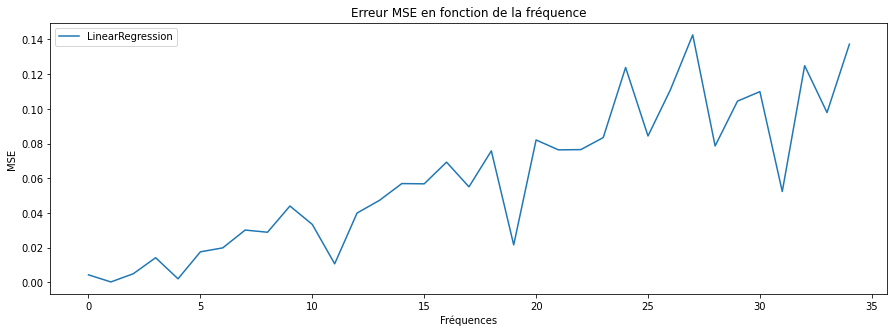

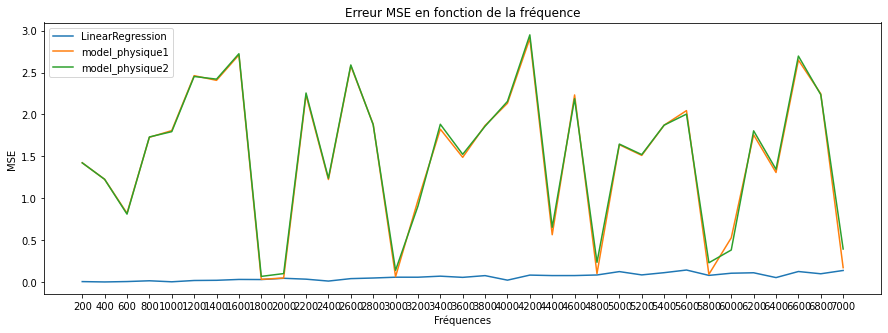

,LinearRegression,model_physique1,model_physique2
200,0.004405,1.422478,1.422478
400,0.000309,1.225870,1.225580
600,0.005020,0.820703,0.810101
800,0.014264,1.727219,1.731355
1000,0.002119,1.807496,1.794784
1200,0.017646,2.463325,2.453558
1400,0.019932,2.407210,2.421551
1600,0.030187,2.711151,2.724862
1800,0.028934,0.031250,0.066703
2000,0.044044,0.047515,0.100078


In [19]:
nb_freq = 35
freq_train = [200*i for i in range(1,nb_freq+1)]
freq_test = freq_train

tabMSE = evaluateur.tabMSEFreq(freq_train)
tabMSE

#### Matrice erreurs MSE pour chaque case

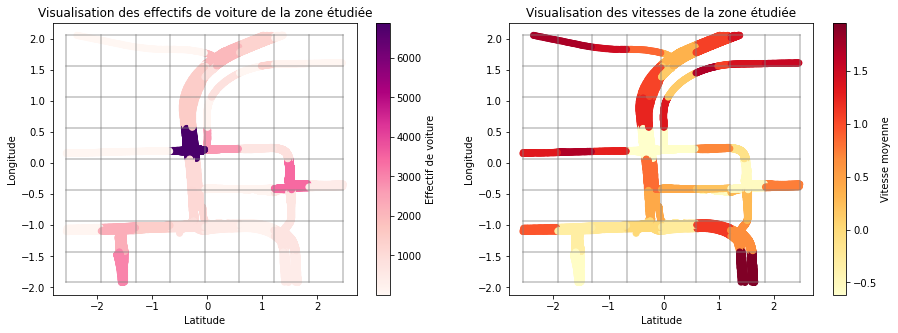

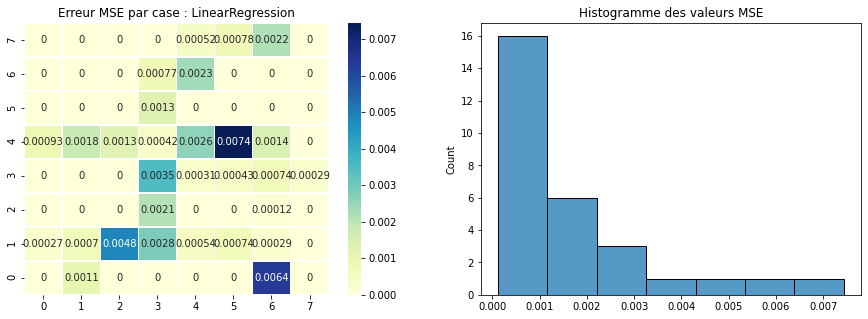

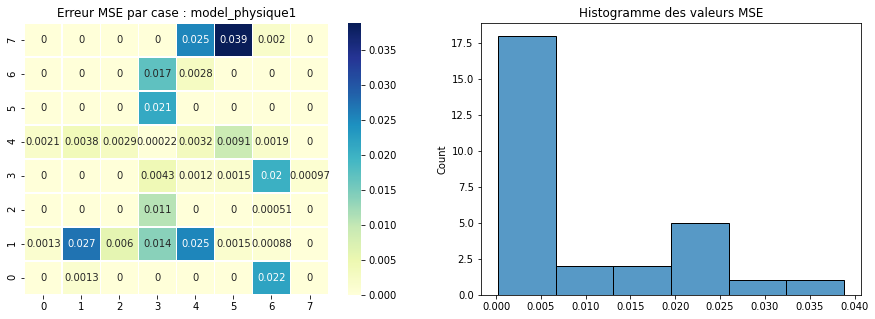

In [ ]:
min_datapoints = 5

#fréquences
freq_train = 400
freq_test = freq_train

dv.afficher_traffic(df, lat_min,lat_max, long_min, long_max, n_interval)

#On apprend sur toutes les données puis on prédit et calcule l'erreur MSE sur chaque case
evaluateur.matMSECase(freq_train,freq_test,lat_min,long_min,e_x,e_y,min_datapoints,train_size,n_interval)